In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns

from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [27]:
heart_disease = fetch_ucirepo(id=45)

In [28]:
df = heart_disease.data.original
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1


1. Predict the presence of heart disease in the patients based on personal features (such as sex and age) and medical features.

2. The ca variable is right-skewed with a high percentage of 0. Additionally, the violin plot shows that patients without heart disease (num = 0) are concentrated in ca = 0. We treat it as a categorical variable to avoid issues in following steps that use models sensitivity to feature scaling. (This imbalance can not be solved by StandardScaler or log transfomation since the range of ca is integer 0 to 3.)

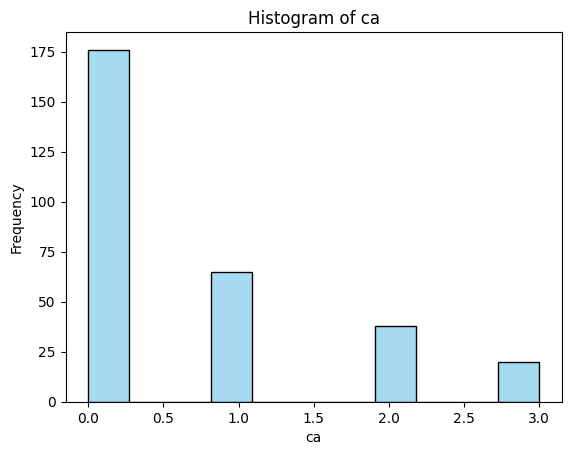

In [29]:
sns.histplot(
    data=df,
    x = 'ca',
    color='skyblue',
    edgecolor='black'
)

plt.title('Histogram of ca')
plt.xlabel('ca')
plt.ylabel('Frequency')
plt.show()

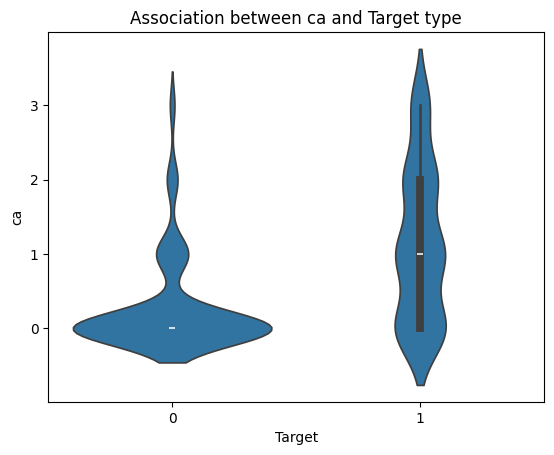

In [30]:
df_transfer = df.copy()
df_transfer['target'] = df_transfer['num'].apply(lambda x: 1 if x > 0 else 0)
sns.violinplot(x='target', y='ca', data=df_transfer)
plt.xlabel('Target')
plt.ylabel('ca')
plt.title('Association between ca and Target type')
plt.show()

The oldpeak variable is right-skewed, indicating that a log transformation could help normalize the distribution. However, since this variable contains many zero values, a small pseudo-value (e.g., 0.001) should be added to the oldpeak before applying the transformation to avoid taking the logarithm of zero.

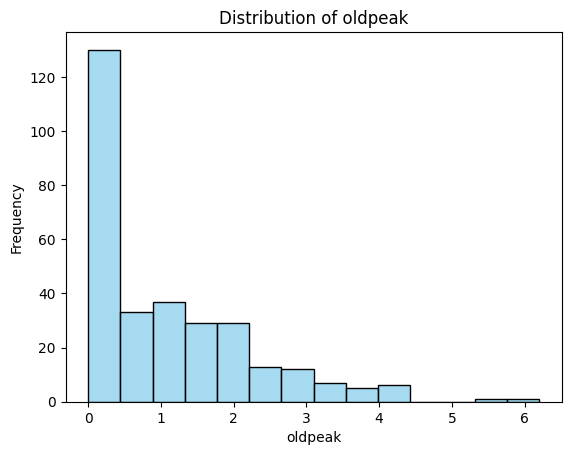

In [31]:
sns.histplot(
    data=df,
    x = 'oldpeak',
    color='skyblue',
    edgecolor='black'
)


plt.title('Distribution of oldpeak')
plt.xlabel('oldpeak')
plt.ylabel('Frequency')
plt.show()

In [32]:
df['oldpeak'] = np.log(df['oldpeak'] + 1)

3.

Variables & data types (based on dtype function & variable description):

Numerical: age, trestbps, chol,thalach,oldpeak

Categorical: sex, cp, fbs, restecg, exang, slope, thal, and ca

Target variable is num which is categorical.

distribution of target variable: The dataset has 164 observations of patients with heart disease (num=0) and 139 observations of patients without haert disease (num>0). (55 with num = 1, 36 with num = 2, 35 with num = 3, and 13 with num = 4.)

Number of obs: There are total 303 observations(rows) and 14 kay variables(columns) in this dataset.

In [33]:
df.shape

(303, 14)

In [34]:
var_inf = heart_disease.variables
print(var_inf)

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [35]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

In [36]:
df['num'].value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [37]:
cat_col = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
num_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[num_col].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,0.569944
std,9.038662,17.599748,51.776918,22.875003,0.524336
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.587787
75%,61.000000,140.000000,275.000000,166.000000,0.955511
max,77.000000,200.000000,564.000000,202.000000,1.974081


4

In [38]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df['num'].nunique()

2

5.
Heatmap shows correlation between numerical variables. The numberical variables have no significant correlation (>0.5) where affect feature selection.

The boxplot of oldpeak vs slope shows significant differences in the distribution of oldpeak across different slope categories. Similarly, the boxplot of oldpeak vs restecg shows significant higher oldpeak in restecg category value 1. After evaluating feature importance in following steps, we may drop oldpeak if it is not importance to reduce multicollinearity.

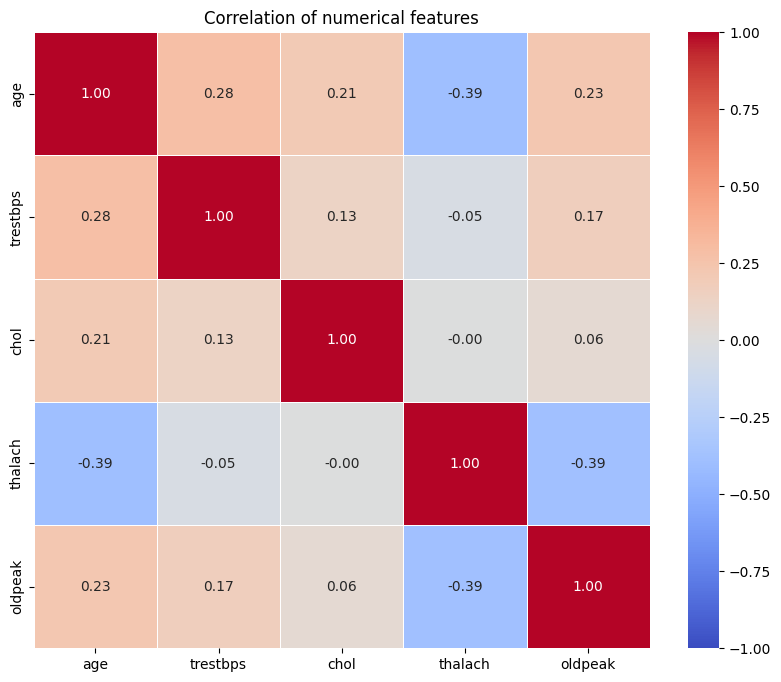

In [39]:
numerical_vars = df[num_col]
scaler = StandardScaler()
numerical_vars_scaled = pd.DataFrame(scaler.fit_transform(numerical_vars), columns=numerical_vars.columns)
corr_matrix = numerical_vars_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation of numerical features')
plt.show()

<Axes: xlabel='restecg', ylabel='oldpeak'>

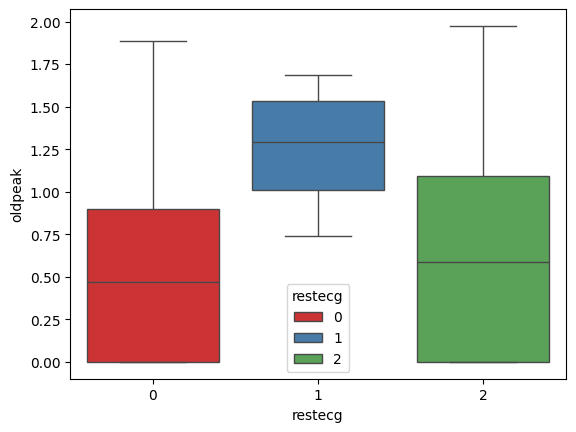

In [51]:
sns.boxplot(
    x = 'restecg',
    y = 'oldpeak',
    data=df,
    hue='restecg',
    palette='Set1'
)

<Axes: xlabel='slope', ylabel='oldpeak'>

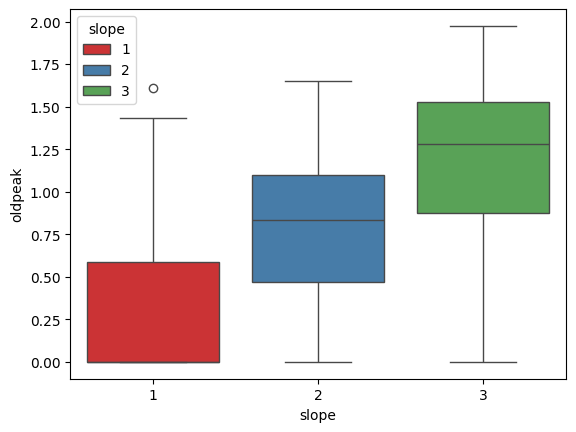

In [53]:
sns.boxplot(
    x = 'slope',
    y = 'oldpeak',
    data=df,
    hue='slope',
    palette='Set1'
)

6

In [42]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [43]:
df=df.dropna()
print(df.shape)

(297, 14)


In [44]:
df.isna().sum().sum()

np.int64(0)

7

In [45]:
# select numerical columns
clust_df = df[num_col]
print(clust_df.head())

   age  trestbps  chol  thalach   oldpeak
0   63       145   233      150  1.193922
1   67       160   286      108  0.916291
2   67       120   229      129  1.280934
3   37       130   250      187  1.504077
4   41       130   204      172  0.875469


In [46]:
scaler = StandardScaler()
clust_df_scaled = scaler.fit_transform(clust_df)
clust_df_scaled = pd.DataFrame(clust_df_scaled, columns=clust_df.columns)
print(clust_df_scaled.head())

        age  trestbps      chol   thalach   oldpeak
0  0.936181  0.750380 -0.276443  0.017494  1.174672
1  1.378929  1.596266  0.744555 -1.816334  0.645463
2  1.378929 -0.659431 -0.353500 -0.899420  1.340529
3 -1.941680 -0.095506  0.051047  1.633010  1.765876
4 -1.498933 -0.095506 -0.835103  0.978071  0.567650


In [54]:
pca_model = PCA()
df_pca = pd.DataFrame(pca_model.fit_transform(clust_df_scaled))

In [55]:
pd.DataFrame([df_pca.iloc[:,:5].std(axis=0, ddof=0).to_numpy(),
              pca_model.explained_variance_ratio_[:5],
              np.cumsum(pca_model.explained_variance_ratio_[:5])],
             index=['Standard deviation', 'Proportion of variance', 'Cumulative proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard deviation,1.352807,1.052539,0.927735,0.858168,0.681858
Proportion of variance,0.366017,0.221567,0.172138,0.147290,0.092986
Cumulative proportion,0.366017,0.587585,0.759723,0.907014,1.000000


In [56]:
Xpcs = df_pca.iloc[:,:3]

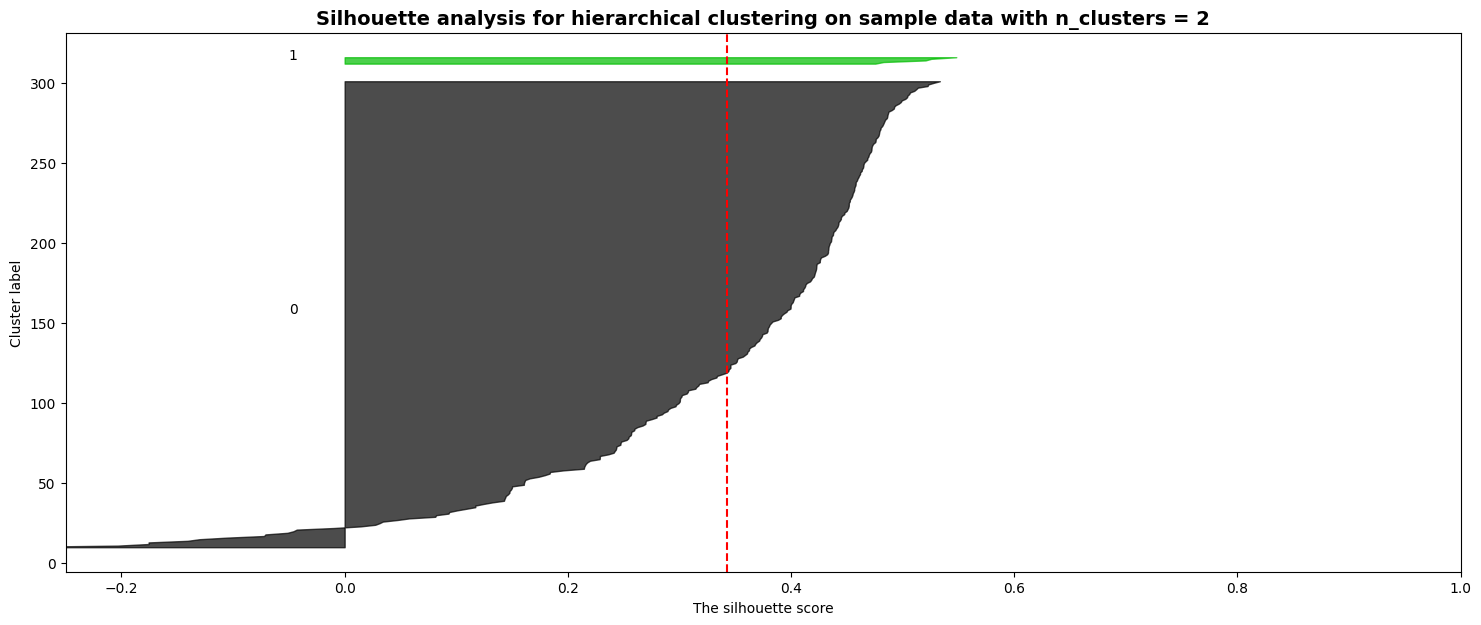

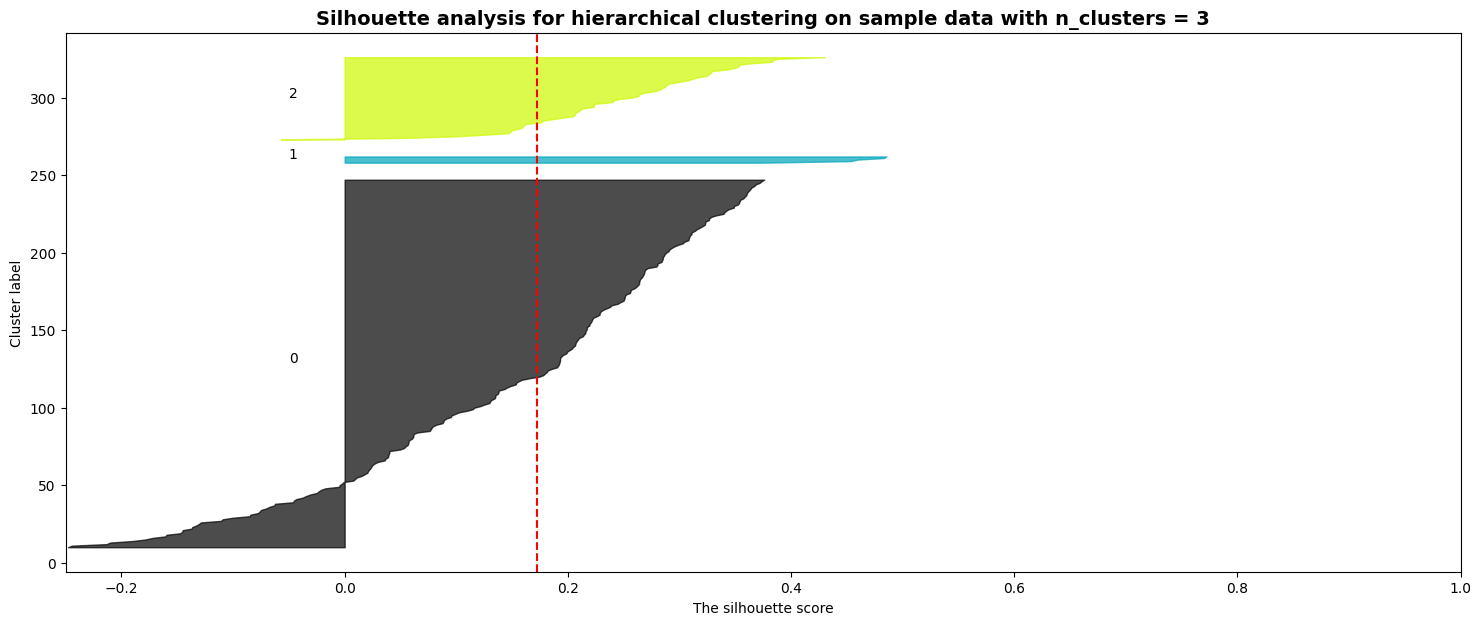

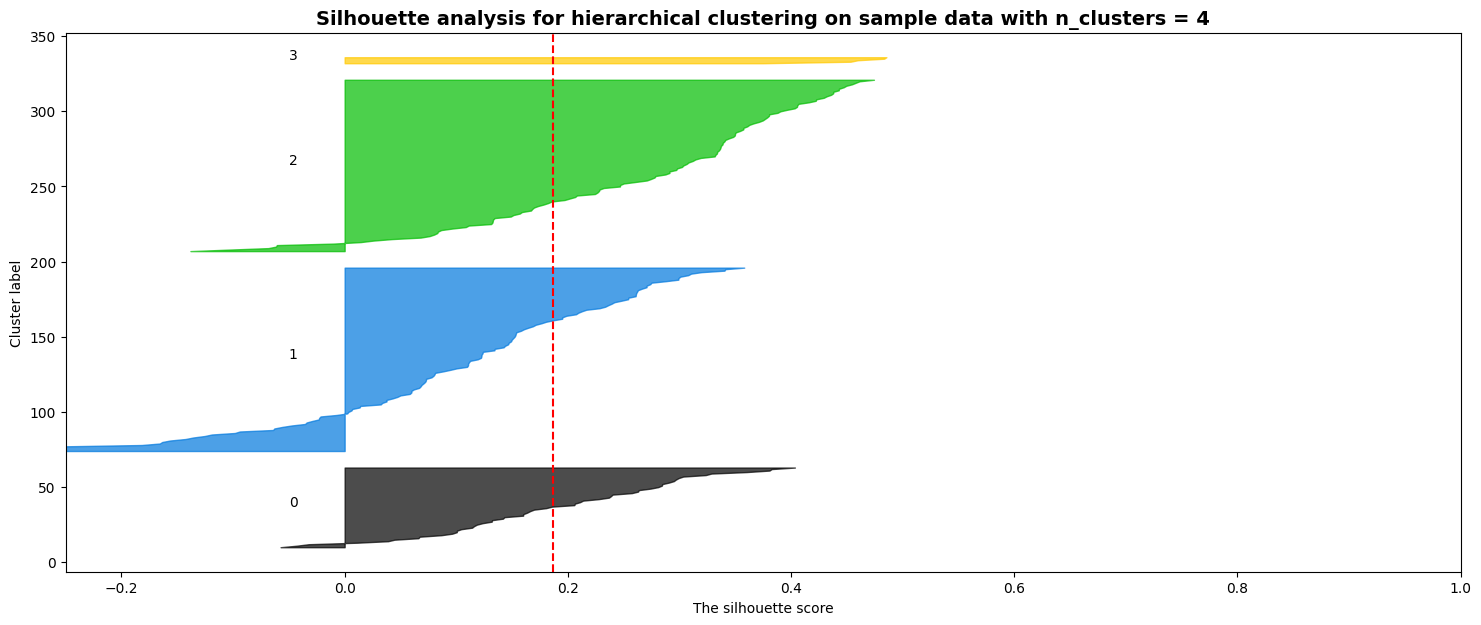

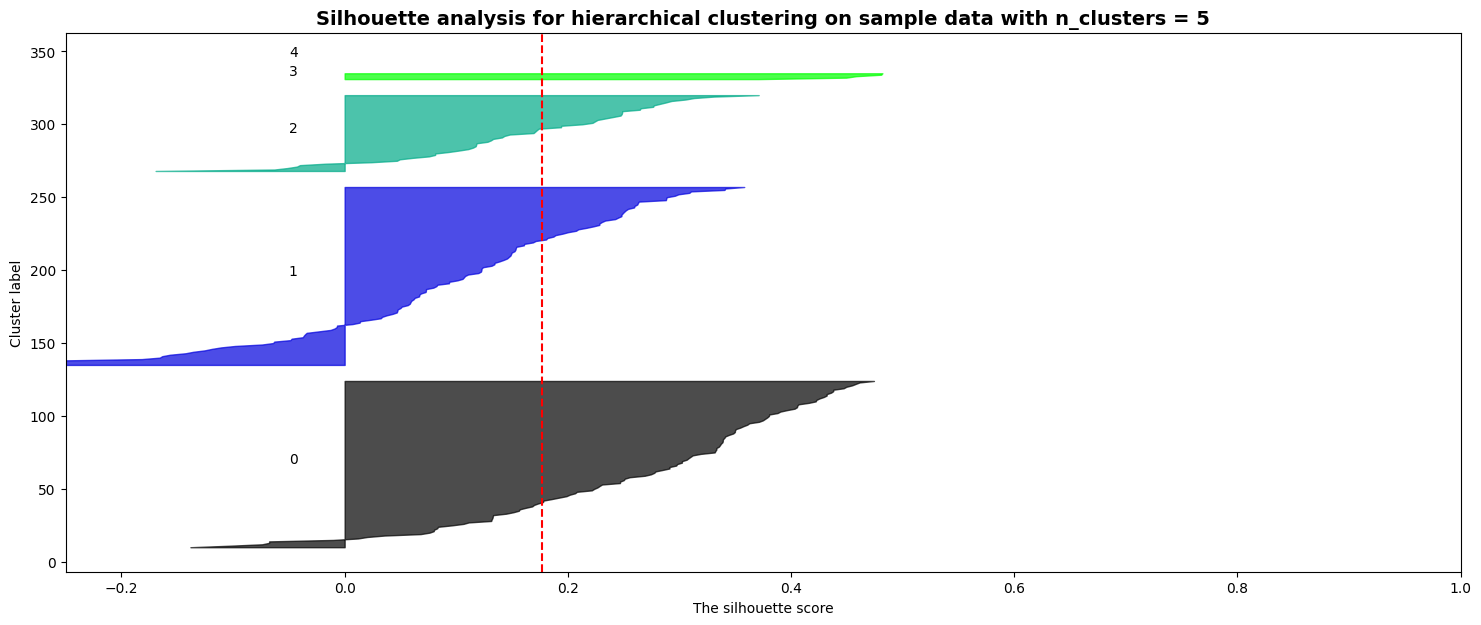

In [60]:
# hierarchical clustering
range_n_clusters = [2,3,4,5]
for n_clusters in range_n_clusters:
    model_hc = AgglomerativeClustering(linkage="complete", n_clusters=n_clusters)
    model_hc.fit(Xpcs)
    silhouette_avg_hc = silhouette_score(clust_df_scaled, model_hc.labels_)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(
        clust_df_scaled,
        model_hc.labels_
        )
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.25, 1])# change this based on the silhouette range

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[model_hc.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette score")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_hc, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for hierarchical clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

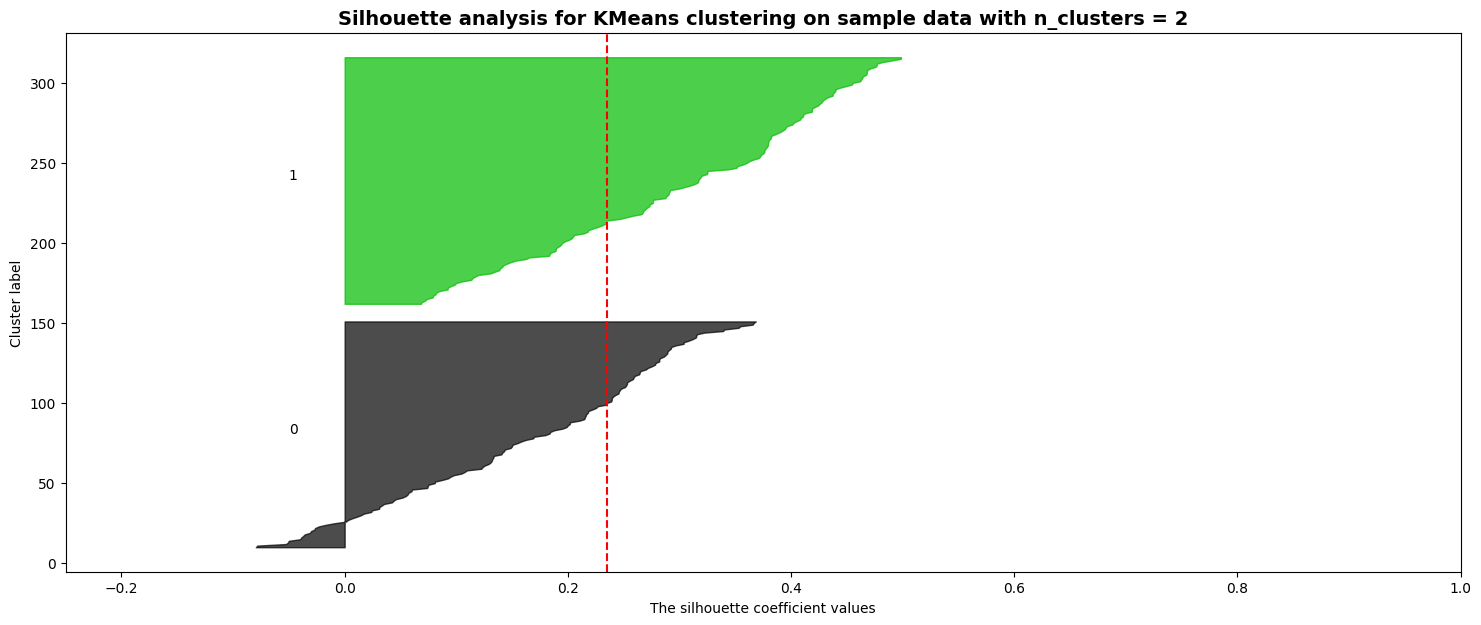

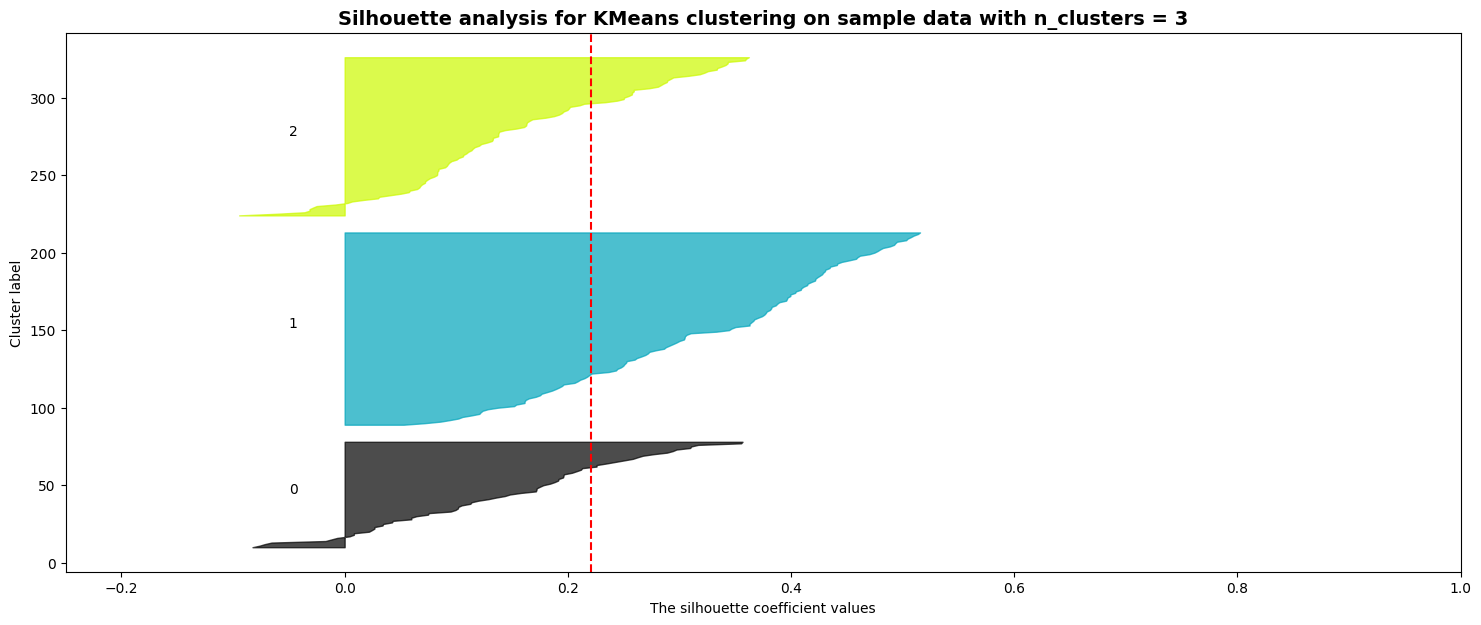

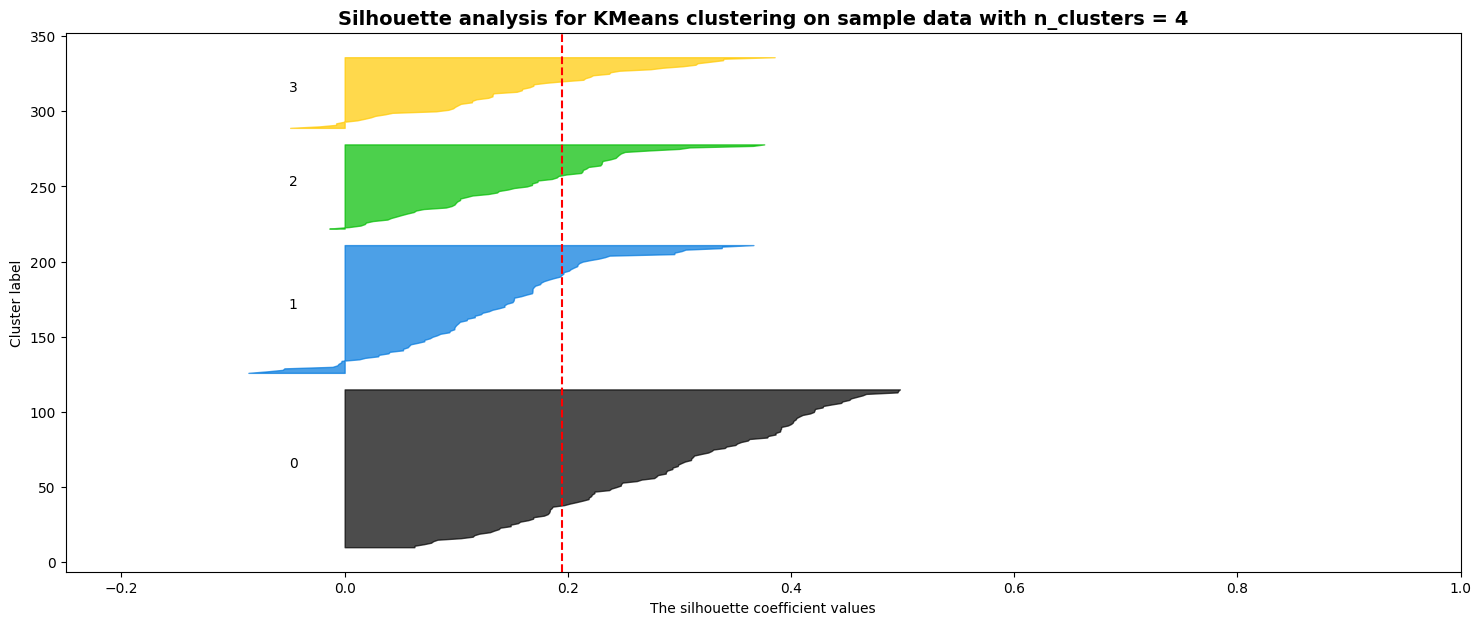

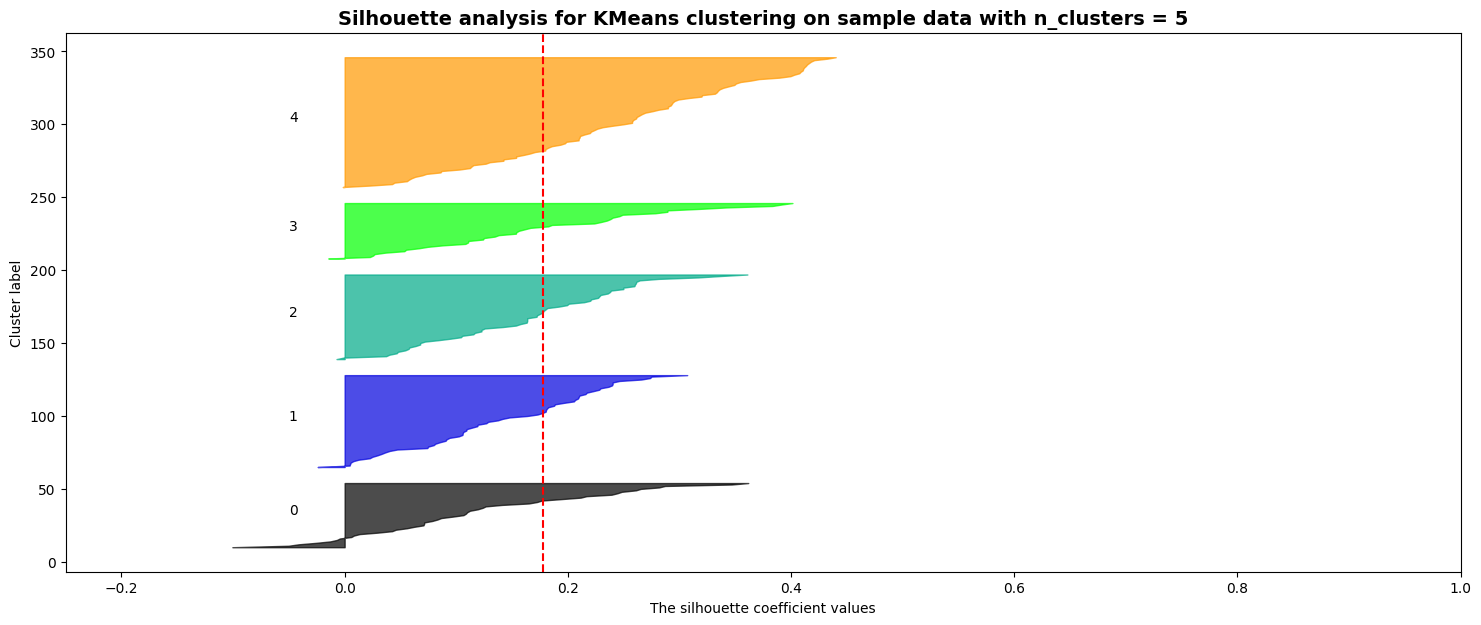

In [61]:
# kmeans
range_n_clusters = range(2,6)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, n_init = 20, random_state=0)
    cluster_labels_km = km.fit_predict(Xpcs)
    silhouette_avg_km = silhouette_score(clust_df_scaled, cluster_labels_km)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clust_df_scaled, cluster_labels_km)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.25, 1])# change this based on the silhouette range

    y_lower = 10

    for i in range(n_clusters):
        # aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

It seems 2 clusters hierarchical clustering is a good fit since the highest average silhouette score (> 0.3) and a relatively low number of negative silhouette values.

In [62]:
# create a new dataset df_cluster for Qeustion 15

hc2 = AgglomerativeClustering(linkage="complete", n_clusters=2)
hc2.fit(Xpcs)
df_cluster = df.copy()
df_cluster['cluster'] = hc2.labels_
df_cluster['cluster'] = df_cluster['cluster'].astype('category')

8

In [63]:
# one-hot encode categorical variables and drop one level
df_dummies = pd.get_dummies(df, columns=cat_col, drop_first=True, dtype=int)
print(df_dummies.head())
X = df_dummies.drop(columns = ['num'])
y = df_dummies['num']

   age  trestbps  chol  thalach   oldpeak  num  sex_1  cp_2  cp_3  cp_4  ...  \
0   63       145   233      150  1.193922    0      1     0     0     0  ...   
1   67       160   286      108  0.916291    1      1     0     0     1  ...   
2   67       120   229      129  1.280934    1      1     0     0     1  ...   
3   37       130   250      187  1.504077    0      1     0     1     0  ...   
4   41       130   204      172  0.875469    0      0     1     0     0  ...   

   restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  \
0          0          1        0        0        1         1         0   
1          0          1        1        1        0         0         0   
2          0          1        1        1        0         0         1   
3          0          0        0        0        1         0         0   
4          0          1        0        0        0         0         0   

   ca_1.0  ca_2.0  ca_3.0  
0       0       0       0  
1       0       0 

In [64]:
# scale the numerical variables
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
print(X.head(3))

        age  trestbps      chol   thalach   oldpeak  sex_1  cp_2  cp_3  cp_4  \
0  0.936181  0.750380 -0.276443  0.017494  1.174672      1     0     0     0   
1  1.378929  1.596266  0.744555 -1.816334  0.645463      1     0     0     1   
2  1.378929 -0.659431 -0.353500 -0.899420  1.340529      1     0     0     1   

   fbs_1  restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  \
0      1          0          1        0        0        1         1         0   
1      0          0          1        1        1        0         0         0   
2      0          0          1        1        1        0         0         1   

   ca_1.0  ca_2.0  ca_3.0  
0       0       0       0  
1       0       0       1  
2       0       1       0  


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
    )